ASFD-DCL Training (Seed 42)
Loaded train data: (7352, 128, 9), (7352,)
Loaded test data: (2947, 128, 9), (2947,)

--------------------------------------------------------------------------------
TRAINING START
--------------------------------------------------------------------------------
[01/50] Train Loss: 0.9924 | Test F1: 0.8990 (Best: 0.8990)
[02/50] Train Loss: 0.4806 | Test F1: 0.7985 (Best: 0.8990)
[03/50] Train Loss: 0.3938 | Test F1: 0.9125 (Best: 0.9125)
[04/50] Train Loss: 0.3524 | Test F1: 0.8909 (Best: 0.9125)
[05/50] Train Loss: 0.3305 | Test F1: 0.9639 (Best: 0.9639)
[06/50] Train Loss: 0.3213 | Test F1: 0.9500 (Best: 0.9639)
[07/50] Train Loss: 0.3213 | Test F1: 0.9562 (Best: 0.9639)
[08/50] Train Loss: 0.3122 | Test F1: 0.9572 (Best: 0.9639)
[09/50] Train Loss: 0.3070 | Test F1: 0.9562 (Best: 0.9639)
[10/50] Train Loss: 0.3062 | Test F1: 0.9515 (Best: 0.9639)
[11/50] Train Loss: 0.3000 | Test F1: 0.9646 (Best: 0.9646)
[12/50] Train Loss: 0.3022 | Test F1: 0.9629 (Bes

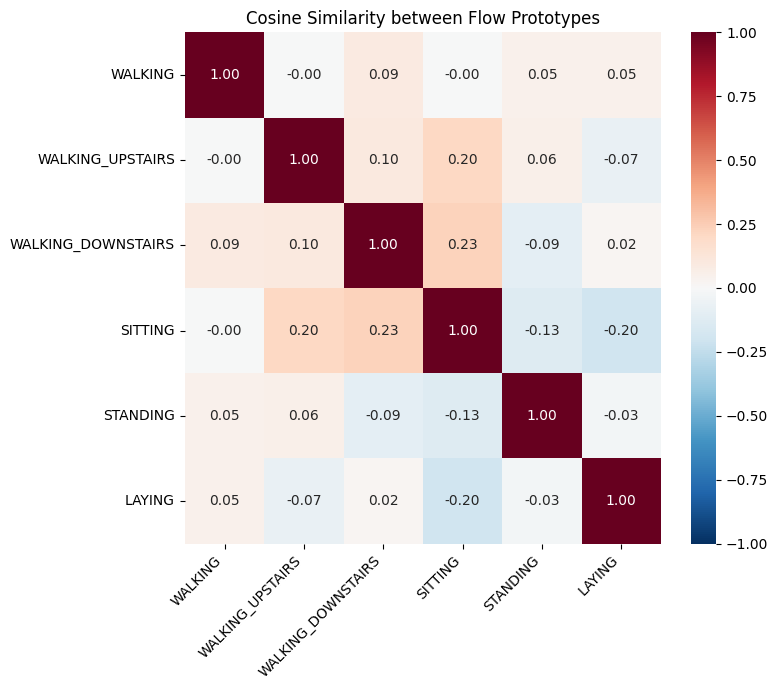


Classification Report
                    precision    recall  f1-score   support

           WALKING     0.9879    0.9859    0.9869       496
  WALKING_UPSTAIRS     0.9909    0.9278    0.9583       471
WALKING_DOWNSTAIRS     0.9185    0.9929    0.9542       420
           SITTING     0.9669    0.8921    0.9280       491
          STANDING     0.9211    0.9662    0.9431       532
            LAYING     0.9835    1.0000    0.9917       537

          accuracy                         0.9610      2947
         macro avg     0.9615    0.9608    0.9604      2947
      weighted avg     0.9621    0.9610    0.9608      2947

Saved Confusion Matrix to ASF_0.00_seed42_cm.png


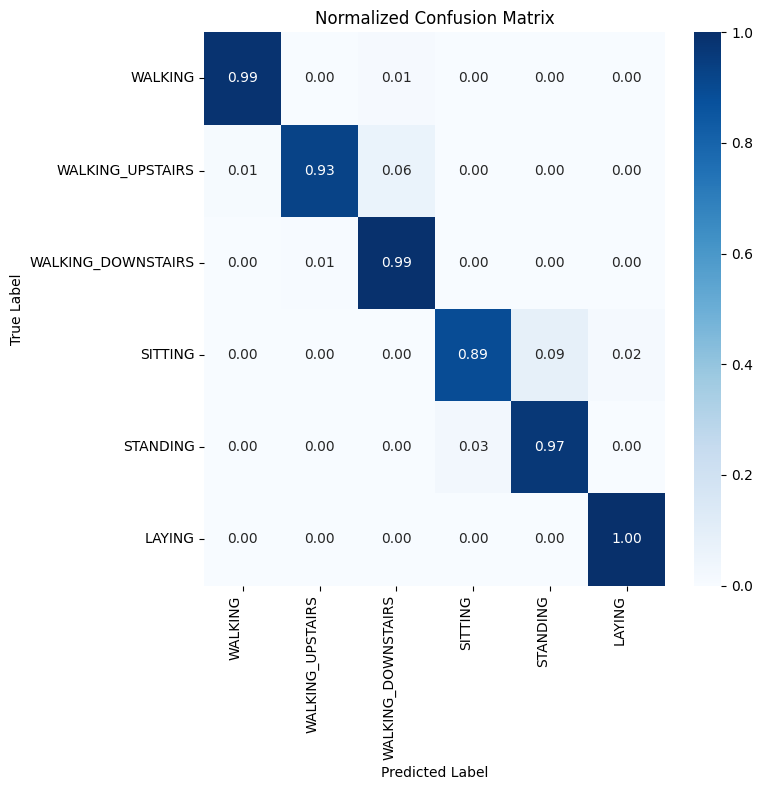

Extracting features for t-SNE...
Saved t-SNE to ASF_0.00_seed42_tsne.png


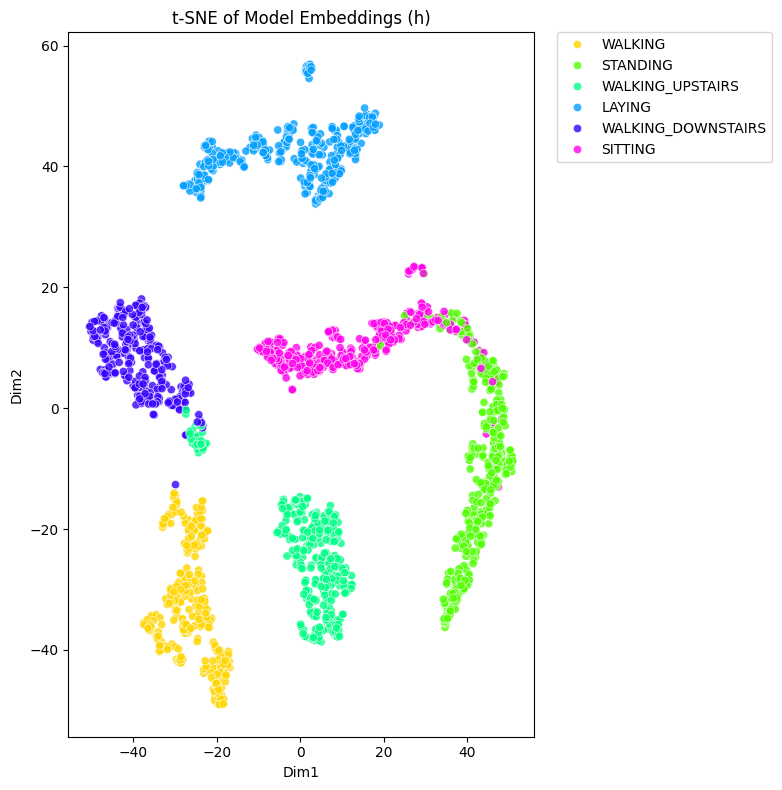


[Done] All analysis completed.


In [1]:
"""
ASF-DCL: Action State Flow with Dynamics-aware Contrastive Learning
(Visualization Integrated Version)
"""

import os
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from tqdm import tqdm

# ------------------------------------------------------------------------------
# 0. Utils & Config
# ------------------------------------------------------------------------------
# UCI-HAR LABELS (시각화 라벨링용)
ACTIVITY_LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING",
]

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ------------------------------------------------------------------------------
# 1. Visualization & Analysis Functions (NEW)
# ------------------------------------------------------------------------------
def plot_classification_results(model, dataloader, device, save_path=None):
    """Confusion Matrix 및 Report 출력"""
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.numpy())

    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(classification_report(all_targets, all_preds, target_names=ACTIVITY_LABELS, digits=4, zero_division=0))

    cm = confusion_matrix(all_targets, all_preds, normalize='true')

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=ACTIVITY_LABELS, yticklabels=ACTIVITY_LABELS)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"Saved Confusion Matrix to {save_path}")

    plt.show()
    plt.close()

def visualize_tsne(model, dataloader, device, save_path=None, max_points=2000):
    """모델의 Feature(h)를 추출하여 t-SNE 시각화"""
    model.eval()
    all_features = []
    all_labels = []

    print("Extracting features for t-SNE...")
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            # 이 모델은 return_details=True일 때 feature(h)를 딕셔너리로 반환함
            _, details = model(x, return_details=True)
            feat_vec = details['h'] # (B, hidden_dim)

            all_features.append(feat_vec.cpu().numpy())
            all_labels.append(y.numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # 샘플링
    N = all_features.shape[0]
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)
        X_sel = all_features[idx]
        y_sel = all_labels[idx]
    else:
        X_sel = all_features
        y_sel = all_labels

    # t-SNE 설정
    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    tsne = TSNE(n_components=2, random_state=42, perplexity=effective_perp, init="pca", learning_rate="auto")
    proj = tsne.fit_transform(X_sel)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    sns.scatterplot(data=df, x="Dim1", y="Dim2", hue="label",
                    palette=sns.color_palette("hsv", n_colors=len(ACTIVITY_LABELS)),
                    alpha=0.8)
    plt.title("t-SNE of Model Embeddings (h)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches="tight")
        print(f"Saved t-SNE to {save_path}")

    plt.show()
    plt.close()

def analyze_flow_and_prototypes(model, save_path_prefix=None):
    """Flow Prototypes 통계 및 유사도 분석"""
    print("\n" + "="*80)
    print("Flow & Prototype Analysis")
    print("="*80)

    if not hasattr(model, 'flow_prototypes'):
        print("Model has no 'flow_prototypes'. Skipping analysis.")
        return

    protos = model.flow_prototypes.detach().cpu().numpy() # (Num_classes, Hidden_dim)
    num_protos, dim = protos.shape

    # 1. 통계표
    df_stats = pd.DataFrame(index=ACTIVITY_LABELS[:num_protos])
    df_stats['L2 Norm'] = np.linalg.norm(protos, axis=1)
    df_stats['Mean'] = np.mean(protos, axis=1)
    df_stats['Std'] = np.std(protos, axis=1)
    print("\n[Prototype Statistics]")
    print(df_stats.round(4))

    # 2. 유사도 히트맵
    protos_tensor = torch.tensor(protos)
    protos_norm = F.normalize(protos_tensor, p=2, dim=1)
    sim_matrix = torch.mm(protos_norm, protos_norm.t()).numpy()

    plt.figure(figsize=(8, 7))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1,
                xticklabels=ACTIVITY_LABELS[:num_protos],
                yticklabels=ACTIVITY_LABELS[:num_protos])
    plt.title("Cosine Similarity between Flow Prototypes")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    if save_path_prefix:
        plt.savefig(f"{save_path_prefix}_proto_sim.png", dpi=600, bbox_inches='tight')
        print(f"Saved Proto Heatmap to {save_path_prefix}_proto_sim.png")

    plt.show()
    plt.close()


# ------------------------------------------------------------------------------
# 2. Dataset Definition
# ------------------------------------------------------------------------------
class UCIHARDataset(Dataset):
    def __init__(self, data_path, split='train'):
        self.split = split
        if split == 'train':
            y = np.loadtxt(os.path.join(data_path, 'train', 'y_train.txt'))
            signal_path = os.path.join(data_path, 'train', 'Inertial Signals')
        else:
            y = np.loadtxt(os.path.join(data_path, 'test', 'y_test.txt'))
            signal_path = os.path.join(data_path, 'test', 'Inertial Signals')

        signals = []
        signal_files = [
            'body_acc_x', 'body_acc_y', 'body_acc_z',
            'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
            'total_acc_x', 'total_acc_y', 'total_acc_z'
        ]

        for signal_file in signal_files:
            filename = os.path.join(signal_path, f'{signal_file}_{split}.txt')
            signal_data = np.loadtxt(filename)
            signals.append(signal_data)

        self.X = np.stack(signals, axis=-1).astype(np.float32)
        self.y = (y - 1).astype(np.int64)
        print(f"Loaded {split} data: {self.X.shape}, {self.y.shape}")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.LongTensor([self.y[idx]])[0]


# ------------------------------------------------------------------------------
# 3. ASF Model Components
# ------------------------------------------------------------------------------
class LatentEncoder(nn.Module):
    def __init__(self, input_channels=9, latent_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, latent_dim, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(latent_dim)

    def forward(self, x):
        x = x.transpose(1, 2)
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        s = F.relu(self.bn3(self.conv3(h)))
        s = s.transpose(1, 2)
        return s

class FlowComputer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, s):
        B, T, D = s.shape
        flow_raw = s[:, 1:, :] - s[:, :-1, :]
        flow_mag = torch.norm(flow_raw, dim=-1, keepdim=True)
        flow_dir = flow_raw / (flow_mag + 1e-8)
        flow_features = torch.cat([flow_raw, flow_mag.expand(-1, -1, D), flow_dir], dim=-1)
        return flow_features, flow_raw, flow_mag

class FlowEncoder(nn.Module):
    def __init__(self, flow_dim, hidden_dim=64, num_heads=4):
        super().__init__()
        self.flow_embed = nn.Linear(flow_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.flow_conv1 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.flow_conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1, padding=0)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, flow_features):
        h = self.flow_embed(flow_features)
        h_att, _ = self.attention(h, h, h)
        h_att = h_att.transpose(1, 2)
        h = F.relu(self.bn1(self.flow_conv1(h_att)))
        h = F.relu(self.bn2(self.flow_conv2(h)))
        h_pool = torch.mean(h, dim=-1)
        return h_pool

class StateTransitionPredictor(nn.Module):
    def __init__(self, latent_dim=64, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, s_t):
        B, Tm1, D = s_t.shape
        inp = s_t.reshape(B * Tm1, D)
        out = self.net(inp)
        return out.reshape(B, Tm1, D)

class ASFDCLClassifier(nn.Module):
    def __init__(self, input_channels=9, latent_dim=64, hidden_dim=64, num_classes=6, num_heads=4, projection_dim=128):
        super().__init__()
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        self.latent_encoder = LatentEncoder(input_channels, latent_dim)
        self.flow_computer = FlowComputer()
        self.flow_encoder = FlowEncoder(latent_dim * 3, hidden_dim, num_heads)
        self.state_predictor = StateTransitionPredictor(latent_dim, hidden_dim)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

        self.flow_prototypes = nn.Parameter(torch.randn(num_classes, hidden_dim))
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, projection_dim)
        )

    def forward(self, x, return_details=False):
        s = self.latent_encoder(x)
        s_t = s[:, :-1, :]
        s_next = s[:, 1:, :]
        s_pred_next = self.state_predictor(s_t)

        flow_features, flow_raw, flow_mag = self.flow_computer(s)
        h = self.flow_encoder(flow_features)

        z = self.projection_head(h)
        z = F.normalize(z, dim=-1)
        logits = self.classifier(h)

        if not return_details:
            return logits

        details = {
            "s": s, "s_t": s_t, "s_next": s_next, "s_pred_next": s_pred_next,
            "flow_features": flow_features, "flow_raw": flow_raw, "flow_mag": flow_mag,
            "h": h, "z": z, "prototypes": self.flow_prototypes
        }
        return logits, details


# ------------------------------------------------------------------------------
# 4. Losses
# ------------------------------------------------------------------------------
def compute_contrastive_loss(z, labels, temperature=0.07):
    B = z.shape[0]
    device = z.device
    sim_matrix = torch.mm(z, z.t()) / temperature
    labels_expanded = labels.unsqueeze(1)
    positive_mask = (labels_expanded == labels_expanded.t()).float()
    positive_mask = positive_mask - torch.eye(B, device=device)
    mask = torch.eye(B, device=device).bool()
    sim_matrix_masked = sim_matrix.masked_fill(mask, float('-inf'))
    exp_sim = torch.exp(sim_matrix_masked)
    pos_sim = (exp_sim * positive_mask).sum(dim=1)
    all_sim = exp_sim.sum(dim=1)
    has_positive = positive_mask.sum(dim=1) > 0
    if has_positive.sum() == 0:
        return torch.tensor(0.0, device=device)
    loss = -torch.log(pos_sim[has_positive] / (all_sim[has_positive] + 1e-8))
    return loss.mean()

def compute_asf_dcl_losses(logits, details, labels, lambda_dyn=0.1, lambda_flow=0.05, lambda_proto=0.1, lambda_contrast=0.15, dyn_classes=(0, 1, 2), static_classes=(3, 4, 5), dyn_target=0.7, static_target=0.1, proto_tau=0.1, contrast_temp=0.07):
    device = logits.device
    cls_loss = F.cross_entropy(logits, labels, label_smoothing=0.05)

    s_next = details["s_next"]
    s_pred_next = details["s_pred_next"]
    dyn_loss = F.mse_loss(s_pred_next, s_next)

    flow_mag = details["flow_mag"]
    B, Tm1, _ = flow_mag.shape
    flow_mean = flow_mag.mean(dim=1).view(B)
    dyn_mask = torch.zeros_like(flow_mean, dtype=torch.bool)
    static_mask = torch.zeros_like(flow_mean, dtype=torch.bool)
    for c in dyn_classes: dyn_mask = dyn_mask | (labels == c)
    for c in static_classes: static_mask = static_mask | (labels == c)

    flow_prior_loss = torch.tensor(0.0, device=device)
    if dyn_mask.any():
        dyn_flow = flow_mean[dyn_mask]
        flow_prior_loss += F.mse_loss(dyn_flow, torch.full_like(dyn_flow, dyn_target))
    if static_mask.any():
        static_flow = flow_mean[static_mask]
        flow_prior_loss += F.mse_loss(static_flow, torch.full_like(static_flow, static_target))

    h = details["h"]
    prototypes = details["prototypes"]
    h_norm = F.normalize(h, dim=-1)
    proto_norm = F.normalize(prototypes, dim=-1)
    sim = h_norm @ proto_norm.t()
    proto_logits = sim / proto_tau
    proto_loss = F.cross_entropy(proto_logits, labels, label_smoothing=0.05)

    z = details["z"]
    contrast_loss = compute_contrastive_loss(z, labels, temperature=contrast_temp)

    total_loss = cls_loss + lambda_dyn * dyn_loss + lambda_flow * flow_prior_loss + lambda_proto * proto_loss + lambda_contrast * contrast_loss

    loss_dict = {
        "total": total_loss.item(), "cls": cls_loss.item(), "dyn": dyn_loss.item(),
        "flow_prior": flow_prior_loss.item(), "proto": proto_loss.item(), "contrast": contrast_loss.item()
    }
    return total_loss, loss_dict


# ------------------------------------------------------------------------------
# 5. Train / Evaluation
# ------------------------------------------------------------------------------
def train_epoch(model, dataloader, optimizer, device, lambda_dyn, lambda_flow, lambda_proto, lambda_contrast):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    loss_accumulator = {"cls": 0.0, "dyn": 0.0, "flow_prior": 0.0, "proto": 0.0, "contrast": 0.0}

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits, details = model(x, return_details=True)
        loss, loss_dict = compute_asf_dcl_losses(logits, details, y, lambda_dyn=lambda_dyn, lambda_flow=lambda_flow, lambda_proto=lambda_proto, lambda_contrast=lambda_contrast)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        for k in loss_accumulator: loss_accumulator[k] += loss_dict[k]
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    for k in loss_accumulator: loss_accumulator[k] /= len(dataloader)
    return avg_loss, acc, f1, loss_accumulator

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(y.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return avg_loss, acc, f1, cm


# ------------------------------------------------------------------------------
# 6. Main
# ------------------------------------------------------------------------------
def main():
    SEED = 42
    set_seed(SEED)

    DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/HAR_data/UCI_HAR' # 경로 확인 필요
    BATCH_SIZE = 64
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters
    LAMBDA_DYN = 0.05
    LAMBDA_FLOW = 0.02
    LAMBDA_PROTO = 0.05
    LAMBDA_CONTRAST = 0.0

    print(f"ASFD-DCL Training (Seed {SEED})")

    # 1. Dataset & Loader
    train_dataset = UCIHARDataset(DATA_PATH, split='train')
    test_dataset = UCIHARDataset(DATA_PATH, split='test')

    g = torch.Generator()
    g.manual_seed(SEED)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, worker_init_fn=seed_worker, generator=g)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, worker_init_fn=seed_worker, generator=g)

    # 2. Model
    model = ASFDCLClassifier(input_channels=9, latent_dim=64, hidden_dim=64, num_classes=6, num_heads=4, projection_dim=128).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    # 3. Training Loop
    print("\n" + "-"*80 + "\nTRAINING START\n" + "-"*80)
    best_f1 = 0.0
    best_acc = 0.0

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        train_loss, train_acc, train_f1, _ = train_epoch(
            model, train_loader, optimizer, DEVICE,
            LAMBDA_DYN, LAMBDA_FLOW, LAMBDA_PROTO, LAMBDA_CONTRAST
        )
        test_loss, test_acc, test_f1, _ = evaluate(model, test_loader, DEVICE)
        scheduler.step()

        if test_f1 > best_f1:
            best_f1 = test_f1
            best_acc = test_acc

        print(f"[{epoch+1:02d}/{NUM_EPOCHS}] Train Loss: {train_loss:.4f} | Test F1: {test_f1:.4f} (Best: {best_f1:.4f})")

    # 4. Save Model
    save_name = f"ASF_{LAMBDA_CONTRAST:.2f}_seed{SEED}.pth"
    torch.save(model.state_dict(), save_name)
    print(f"\nSaved best model to: {save_name}")

    # --------------------------------------------------------------------------
    # 5. Run Analysis & Visualization (New Integrated Part)
    # --------------------------------------------------------------------------
    print("\n" + "#"*80)
    print("STARTING ANALYSIS & VISUALIZATION")
    print("#"*80)

    # 파일 이름 prefix 생성
    file_id = os.path.splitext(save_name)[0]

    # (1) Flow & Prototypes Analysis
    # 이쁜 통계표와 유사도 히트맵 출력
    analyze_flow_and_prototypes(model, save_path_prefix=file_id)

    # (2) Confusion Matrix Visualization
    plot_classification_results(model, test_loader, DEVICE, save_path=f"{file_id}_cm.png")

    # (3) t-SNE Visualization
    visualize_tsne(model, test_loader, DEVICE, save_path=f"{file_id}_tsne.png")

    print("\n[Done] All analysis completed.")

if __name__ == "__main__":
    main()